<a href="https://colab.research.google.com/github/MarshaGomez/AI-CS50/blob/master/examples/Multi_Objective_Brachistochrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi Objective. Brachistochrone Problem


The Brachistochone is the famous problem to find the shape of the curve down wich a bead sliding from rest and accelerated by gravity will slip (**without friction**) from one point to another in the least time. 

"The shortest path and the shortest time"

## Base Operations

### Necessary libraries

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import random as rm
import os
import subprocess
import torch
import sys
import torch.optim as optim
import glob
import time
import pickle

from pathlib import Path
from PIL import Image, ImageSequence
from time import sleep
from datetime import datetime, date
from math import sqrt,sin,cos, floor
from scipy.optimize import fsolve
from random import shuffle, randint, sample
from copy import deepcopy

### Hyperparameters

In [77]:
config = {
  "base_path": "/content/gdrive/My Drive/Brachistochrone/MOEA Project/Multi-Objective",
  "objectives": ["Short Time", "Short Path"],
  "n_dimensions": 2,
  "n_individuals": 50,
  "n_generations": 20000,
  "n_points": 20,
  # Probabilities
  "g_ps": 0.7, # selection
  "g_pc": 1, # crossover
  "g_pm": 0.3, # mutation Change less mutation
  "g_elitismo": 0.1,
  "p_variable": True, # Varied the probability
  # Boundaries 
  "xl": 0, # left boundary
  "xr": 1, # rigth boundary
  "yu": 1, # up boundary
  "yl": -1, # low boundary
  "weights": [0.8, 0.2], # [Time, Distance]
  "height": 1,
  "width": 1,
  "seed": 1,
  "show_info": True, # See Important Info
  "show_debug": False, # See Specific info to help the visualization for develop
  "show_plot": True, # See Description Prints
  "save_gif": True, # Save gif image
  "frames_gif": 100,
  "counter": 0,
  "misc_runs_dir": "",
  "gif_dir": "",
}

In [83]:
parents = []
new_individuals = []
base_path = "/content/gdrive/My Drive/Brachistochrone/MOEA Project/Multi-Objective"

### Common Functions

In [105]:
def normalize(data, min, max):
  normal = []
  old_min = np.min(data)
  old_max = np.max(data)
  old_range = old_max - old_min
  
  new_min = min
  new_max = max
  new_range = new_max - new_min

  if old_range == 0:            
      if old_min < new_min:      
          new_value = new_min
      elif old_min > new_max:    
          new_value = new_max
      else:                    
          new_value = old_min
      normal = [new_value for value in data]
  else:
      scale = new_range / old_range
      normal = [(value - old_min) * scale + new_min for value in data]

  return normal

def makeImage(fp_in, fp_out):
  global counter
  counter += 1
  imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
  img = next(imgs)  # extract first image from iterator
  img.save(fp=fp_out, format='GIF', append_images=imgs,
          save_all=True, duration=400, loop=0)
  
  img = Image.open(fp_out)
  
def showGif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

def fitnessFunction(y_no_end_pts, height):
    g = 9.8
    n_segments = len(y_no_end_pts) + 1
    width = 1.0
    delta_x = width/n_segments
    #So if the next point is lower than the previous one, d will be *positive* (i.e., the y axis is down, opposite with the plot axis.)

    y = torch.cat((torch.tensor([height]), y_no_end_pts, torch.tensor([0.0])), dim=0)

    d = torch.stack([-(y[i+1] - y[i]) for i in range(n_segments)])

    temp = torch.stack([torch.tensor(0.0)] + [sum(d[:(i+1)]) for i in range(len(d))])
    v = sqrt(2*g)*torch.sqrt(temp)

    v = v[:-1]
    t = (torch.sqrt(v**2 + 2*g*d) - v)/(g*d/torch.sqrt(d**2 + delta_x**2))

    return(sum(t))

def makeFolders():
  global gif_dir, misc_runs_dir, base_path

  date_string = date.today()
  base_name = f'Env_({date_string})_n-ind={n_individuals}_ps={ps}_pc={pc}_pm={pm}'
  gif_dir = os.path.join(base_path, "gifs/" + base_name)
  misc_runs_dir = os.path.join(base_path, "misc_runs/" + base_name)

  Path(gif_dir).mkdir(parents=True, exist_ok=True)
  Path(misc_runs_dir).mkdir(parents=True, exist_ok=True)

def ParseMetadataFile(path =""):
  with open(path, "a+") as hyper_data:
      hyper_data.write("---------------------------- \nMODEL HYPER-PARAMETERS\n\n")
      for strl,val in globals():
          nline= "%s:%f\n"%(strl,val)
          hyper_data.write(nline)
      hyper_data.write("#wrapper params#\n\n")

def initConf(file=base_path):
  file = file + "/config.json"
  path = Path(file)

  if path.is_file():
    print("\n--------------------------------")
    print(f'Configuration: \n{file}')
    # JSON file
    with open(file, "r") as jsonfile:
      # Reading from file
      myJSON = json.loads(jsonfile.read())
    print(myJSON)

    print("--------------------------------\n")

  else:
    print("\n--------------------------------")
    print(f'Configuration: \n{file}')

    myJSON = json.dumps(config, indent=4)
    print(myJSON)

    with open(file, "w") as jsonfile:
        jsonfile.write(myJSON)
        print("Write successful")

    print("--------------------------------\n")
  

In [106]:
initConf()


--------------------------------
Configuration: 
/content/gdrive/My Drive/Brachistochrone/MOEA Project/Multi-Objective/config.json
{'objectives': ['Short Time', 'Short Path'], 'n_dimensions': 2, 'n_individuals': 50, 'n_generations': 20000, 'n_points': 20, 'g_ps': 0.7, 'g_pc': 1, 'g_pm': 0.3, 'g_elitismo': 0.1, 'p_variable': True, 'xl': 0, 'xr': 1, 'yu': 1, 'yl': -1, 'weights': [0.8, 0.2], 'height': 1, 'width': 1, 'seed': 1, 'show_info': True, 'show_debug': False, 'show_plot': True, 'save_gif': True, 'frames_gif': 100, 'counter': 0, 'misc_runs_dir': '', 'gif_dir': ''}
--------------------------------



## Genetic Algorithm Components



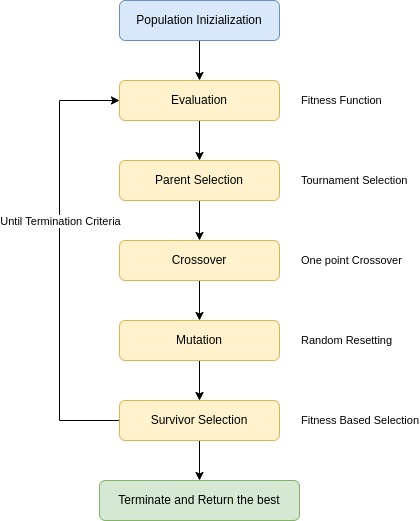

### Initialization


#### Individual

Creating Random Individual

In [7]:
class Individual():

  def __init__(self, 
               n_points=n_points, 
               height=height):

    self.n_segments = n_points
    self.n_points = n_points+1
    self.width = 1.0
    self.height = height
    self.y = [self.height]
    self.x = [0]
    self.delta_x = self.width/self.n_segments

    for i in range(self.n_segments-1):
        self.x.append((i+1)*self.delta_x)
        frac = 1
        self.y.append(-self.height/frac + rm.random()*(self.height - (-self.height/frac)))

    self.x.append(1.0)
    self.y.append(0)

    self.sol = None

    #This is just assuming it dropping vertically and then going horizonally at that speed
    g = 9.8
    t1 = sqrt(2*self.height/g)
    v1 = g*t1
    t2 = self.width/v1
    self.max_FF = 40*(t1 + t2)

#### Population

Creating a Population with n-random Individuals

In [8]:
class Population():
  
  def __init__(self, 
              individual=Individual, 
              n_individuals=n_individuals, 
              show_plot=False, 
              show_info=False, 
              show_debug=False, 
              **kwargs):
    
    self.kwargs_str = '__'.join(['{}={}'.format(x[0], x[1]) for x in kwargs.items()])
    self.individual = individual
    self.class_name = individual.__name__
    self.n_individuals = n_individuals
    self.list_individuals = [[self.createNewIndivid(**kwargs), 0] for i in range(self.n_individuals)]

    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug

    if self.show_plot:
      self.plotPopulation()

    if self.show_info:
      self.printPopulation()

  def createNewIndivid(self, **kwargs):
    return(self.individual(**kwargs))

  def printPopulation(self):
    print("--------------------------------")
    print("Population Created")
    print("--------------------------------")
    print("Number of individuals: ", str(self.n_individuals))
    print("Population Edited Parameters: ", str(self.kwargs_str))
    print("-------------------------------- \n")

  def plotPopulation(self,  **kwargs):
    print("Population Diagram: ")
    print("--------------------------------")
    # plot lines
    for individual in self.list_individuals:
      plt.plot(individual[0].x, individual[0].y)
    plt.show()


  

### Evaluation

In [52]:
class Fitness():

  global show_info

  def __init__(self, 
              population=Population, 
              weights=weights,
              show_plot=False, 
              show_info=False, 
              show_debug=False):
    
    self.population = population
    self.weights = weights
    self.t_ideal = 0
    self.sol = []
    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug

    individual = self.population.list_individuals[0][0]
    self.maxTime = self.getMaxTime(individual)
    self.maxDistance = self.getMaxDistance(individual)
    self.getBestCurve(individual)

    

  '''
  def __del__(self):
    del self.population
    # print("Destructor called")
  '''

  def setPopulation(self, population=Population):
    self.__init__(population)

  def getBestCurve(self, individual):
    w = individual.width
    h = individual.height

    #The coords we've been using (dropped at (0,h), ending at (w,0)), simply add h to y in the end.

    f_t = lambda t: np.cos(t)-1+ (-h/w)*(np.sin(t)-t)
    t = fsolve(f_t,3.14)[0]

    a = w/(t-sin(t))

    t_range = np.linspace(0,t,individual.n_points)

    x = lambda t: a*(t-np.sin(t))
    y = lambda t: h + a*(np.cos(t)-1)

    self.sol = (t_range, x, y)

    sol_numeric_y = []

    for x_pt in individual.x:
        f = lambda t: x(t)-x_pt
        tval = fsolve(f,3.14)[0]
        sol_numeric_y.append(y(tval))

    temp_state = individual.y
    individual.y = sol_numeric_y
    individual.sol_numeric_y = sol_numeric_y
    
    self.t_ideal = self.getFitness(individual)
    individual.y = temp_state

    if self.show_info:
      print('\n-------------------------------------')
      print('Theoretical best time:', self.t_ideal, "\n")

  def getFitness(self, individual):
    g = 9.8
    v = [0]
    t = []
    l = []

    for i in range(len(individual.y)-1):
      v.append(sqrt(2*g*(individual.y[i] - individual.y[i+1])+v[i]**2))
      l.append(sqrt((individual.x[i] - individual.x[i+1])**2 + (individual.y[i] - individual.y[i+1])**2))
      t.append(l[i] / v[i+1])

    F1 = self.weights[0]*(sum(t)/self.maxTime) # Time
    F2 = self.weights[1]*(sum(l)/self.maxDistance) # Distance

    return F1 + F2

  def getMaxTime(self, individual):
    maxTime = sqrt((individual.x[0] - individual.x[-1])**2 + (individual.y[0] - individual.y[-1])**2)

    return maxTime

  def getMaxDistance(self, individual):
    maxDistance = (individual.x[-1] - individual.x[0]) + (individual.y[0] - individual.y[-1])

    return maxDistance

  def getFitnessPopulation(self, sort=False):
    for individual in self.population.list_individuals:
      individual[1] = self.getFitness(individual[0])

    if sort:
      self.sortIndividuals()

    if self.show_info:
      self.printFitnessFunctions()

    return self.population

  def sortIndividuals(self):
    list.sort(self.population.list_individuals, key=lambda fitness: fitness[1])

  def printFitnessFunctions(self):
    print('\n-------------------------------------')
    print('Objective Fitness 1: ', objectives[0])
    print('\n')
    for index, individual in enumerate(self.population.list_individuals):
      print('Individual {:10}     |    Fitness: {:.4f}'.format(index, individual[1]))

  def plotState(self, individual, ax, width, height, color='black', plot_sol=False, plot_label=False):
    # Pass this an axis from another program. It will handle showing it and stuff.
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_title('Comparison Actual Result with Brachistochrone')

    if plot_sol:
      t = self.sol[0]
      x = self.sol[1]
      y = self.sol[2]
      ax.plot(x(t), y(t), '-', color='gray')

      if plot_label:
        ax.text(0.8*width, 0.9*height, 'ideal: {:.3f}'.format(self.t_ideal))

    if plot_label:
      ax.text(0.8*width, 0.8*height, 'cur. best: {:.3f}'.format(self.getFitness(individual)))

    ax.plot(individual.x, individual.y, 'o-', color=color)


  def plotFitnessFunction(self, ax, best, mean):
    ax.clear()
    ax.set_xlabel('Generations')
    ax.set_ylabel('Fitness Function')
    ax.set_title('Best and Mean Results')

    ax.plot(best, label='best', color='dodgerblue')
    ax.plot(mean, label='mean', color='tomato')
    ax.legend()
    ax.text(0.6*len(best), 0.8*max(best), 'best: {:.3f}\nmean: {:.3f}'.format(best[-1], mean[-1]))


### Selection

In [53]:
class Selection():
  
  def __init__(self,
               population=Population, 
               ps=ps,
               show_plot=False,
               show_info=False, 
               show_debug=False):
    
    self.population = population
    self.parents = []
    self.ps = ps
    self.quantity_parents = 3

    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug

  '''
  def __del__(self):
    del self.population
    del self.parents

   #    print("Destructor called")
  '''

  # Probabilistic Selection
  def getProbabilisticSelection(self):
    probability = np.random.uniform(
        low=0, high=1, size=self.population.n_individuals)
    
    probability = probability <= self.ps
    if sum(probability == True) > 0:
      self.quantity_parents = sum(probability == True)

  def getParentsSelection(self):
    self.getProbabilisticSelection()
    for i in range(self.quantity_parents):
      self.parents.append(self.tournamentSelection())

    # self.parents = np.unique(self.parents, axis=0)

    if self.show_info:
      self.printParents()

    return self.parents

  def tournamentSelection(self):
    parents = rm.choices(self.population.list_individuals, k=5)
    list.sort(parents, key=lambda fitness: fitness[1])

    return (parents[0])

  def printParents(self):
    print('\n-------------------------------------')
    print('Selection Parents')
    print('\n')
    for index, individual in enumerate(self.parents):
      print('Individual {:10}     |    Fitness: {:.4f}'.format(index, individual[1]))

  def isSameState(self, other_state):
    max_diff = ((self.n_points-2)*self.height)**2
    diff = (np.array(self.y) - np.array(other_state.y))[1:-1]
    abs_diff_normed = abs(sum(diff))/(self.n_points-2)
    
    if abs_diff_normed < self.sameness_thresh:
      return(True)
    else:
      return(False)

  def deleteDuplicates(self,pop):
    unique_individuals = []
    no_duplicates = []
    
    for index,individual in enumerate(pop):
      is_not_unique = np.any([individual.isSameState(other) for other in no_duplicates])
      if not is_not_unique:
        unique_individuals.append(individual.y)
        no_duplicates.append(individual)

    return(no_duplicates)

### Crossover

In [54]:
class Crossover():
  
  def __init__(self, 
               population=Population, 
               parents=parents, 
               pc=pc,
               show_plot=False, 
               show_info=False, 
               show_debug=False):
 
    self.population = population
    self.parents = parents
    self.new_individuals = []
    self.pc = pc

    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug

  '''
  def __del__(self):
    del self.population
    del self.parents
    del self.new_individuals

    #print("Destructor called")
  '''

  def getNewIndividuals(self):
    rm.shuffle(self.parents)
    n_couple = int((len(self.parents)-1) / 2)
    for i in range(n_couple+1):
      new_child1, new_child2 = self.onePointCrossover(self.parents[i], self.parents[-i-1])
      self.new_individuals.append(new_child1)
      self.new_individuals.append(new_child2)

    if self.show_info:
      self.printNewPopulation()

    return self.new_individuals

  def onePointCrossover(self, parent1, parent2):
    new_child1 = deepcopy(parent1)
    new_child2 = deepcopy(parent2)

    r1 = randint(1,parent1[0].n_points-3)
    r2 = randint(r1+1,parent2[0].n_points-2)

    temp = new_child1[0].y[r1:r2]
    new_child1[0].y[r1:r2] = new_child2[0].y[r1:r2]
    new_child2[0].y[r1:r2] = temp

    return(new_child1, new_child2)


  def printNewPopulation(self):
    print('\n-------------------------------------')
    print('Crossover New Individuals')
    print('\n')
    for index, individual in enumerate(self.new_individuals):
      print('Individual {:10}     |    Individual Y:'.format(index), *individual[0].y, sep=', ')


  def mateAvg(self,other_individ):
    newindivid_1 = deepcopy(self)
    newindivid_2 = deepcopy(other_individ)

    newindivid_1.y = ((np.array(newindivid_1.y) + np.array(newindivid_2.y))/2).tolist()

    return(newindivid_1,newindivid_1)

### Mutation

In [55]:
class Mutation():

  def __init__(self, 
               new_individuals=new_individuals, 
               pm=pm,
               show_plot=False, 
               show_info=False, 
               show_debug=False):
    
    self.new_individuals = new_individuals
    self.pm = pm

    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug

  '''
  def __del__(self):
    del self.new_individuals

    # print("Destructor called")
  '''

  def randomSetMutation(self):
    mutate_individual = []
    mutate_individual.clear()

    for individual in self.new_individuals:
      mutate_individual.append(self.mutate(individual))

    self.new_individuals = mutate_individual
      
    if self.show_info:
      self.printMutation()

    return self.new_individuals

  def mutate(self, individual):
    probability = np.random.uniform(
    low=0, high=1, size=individual[0].n_points-2)

    probability = probability <= pm

    mutate_individual = deepcopy(individual)
    height = individual[0].height
  
    if sum(probability == True) > 0:
      mutate_individual[0].y = mutate_individual[0].y[1: mutate_individual[0].n_points-1]

      # Muta Random Process
      for i in np.where(probability)[0]:
        frac = 2
        mutate_individual[0].y[i] = (-height/frac + rm.random()*(height - (-height/frac)))
      
      mutate_individual[0].y = [height] + mutate_individual[0].y + [0]

    return mutate_individual 

  def printMutation(self):
    print('\n-------------------------------------')
    print('Mutation New Individuals')
    print('\n')
    for index, individual in enumerate(self.new_individuals):
      print('Individual {:10}     |    Individual Y:'.format(index), *individual[0].y, sep=', ')

  def mutateSingle(self):
    index = randint(1, self.n_segments-1)
    new_height = self.y[index] + np.random.normal(scale=self.mutate_strength)
    
    if new_height < self.height:
      self.y[index] = new_height

### Survivor Selection

In [56]:
class Survivor_Selection():
  def __init__(self, 
               population=Population, 
               new_individuals=new_individuals,
               show_plot=False, 
               show_info=False, 
               show_debug=False):
    
    self.population = population
    self.new_individuals = new_individuals
    self.new_population = []

    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug

  '''
  def __del__(self):
    del self.population 
    del self.new_individuals 
    del self.new_population
    # print("Destructor called")
  '''

  def getNewPopulation(self):
    fitness = Fitness(self.population)

    for individual in self.new_individuals:
      individual[1] = fitness.getFitness(individual[0])

    self.new_population = self.population.list_individuals + self.new_individuals

    list.sort(self.new_population, key=lambda fitness: fitness[1])
    
    self.new_population = self.new_population[: self.population.n_individuals]
    self.population.list_individuals = self.new_population

    self.best, self.mean = self.getBestandMean()

    if self.show_info:
      self.printSurvivor()

    return self.population

  
  def getBestandMean(self):
    best = self.population.list_individuals[0][1]
    mean = sum([individual[1] for individual in self.population.list_individuals])/(1.0*len(self.population.list_individuals))
    return((best,mean))

  def printSurvivor(self):
    print('\n-------------------------------------')
    print('Objective Fitness 1: ', objectives[0])
    print('\n')
    for index, individual in enumerate(self.population.list_individuals):
      print('Individual {:10}     |    Fitness: {:.4f}'.format(index, individual[1]))



## Genetic Algorithm execution

In [57]:
class GeneticAlgorithm():

  # Variable = Variation of the Probability between epochs
  def __init__(self, 
               population=Population, 
               generations=n_generations, 
               ps=ps, 
               pc=pc, 
               pm=pm,
               show_plot=False, 
               show_info=False, 
               show_debug=False):
    
    self.population = population
    self.n_generations = n_generations 
    self.parents = []
    self.new_individuals = []
    makeFolders()

    best = []
    mean = []

    start = time.time()
    fitness = Fitness(self.population)

    for i in range(self.n_generations):
      self.population = fitness.getFitnessPopulation()
      selection = Selection(self.population, ps)
      self.parents = selection.getParentsSelection()
      crossover = Crossover(self.population, self.parents, pc)
      self.new_individuals = crossover.getNewIndividuals()
      mutation = Mutation(self.new_individuals, pm)
      self.new_individuals = mutation.randomSetMutation()
      survivor_selection = Survivor_Selection(self.population, self.new_individuals)
      self.population = survivor_selection.getNewPopulation()

      if show_info:
        if i%max(1, int(self.n_generations/20.0))==0:
          self.population.plotPopulation()
          print('Generation {}, current best = {:.3f}, current population size = {}'.format(i, survivor_selection.best, len(self.population.list_individuals)))


      if show_plot:
        best.append(survivor_selection.best)
        mean.append(survivor_selection.mean)

    

    if show_plot:
      fig, axes = plt.subplots(2,1,figsize=(6,8))
      plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
      ax_FF = axes[0]
      ax_state = axes[1]
      individual = self.population.list_individuals[0][0]
      fitness.plotFitnessFunction(ax_FF, best, mean)
      fitness.plotState(individual, ax_state, width, height, color='tomato', plot_sol=True, plot_label=True)

      fig.canvas.draw()

    end = time.time()

    print('\n-------------------------------------')
    print("Process Complete")
    print('-------------------------------------\n')
    print("Object Fitness:", *objectives, sep=', ')
    print("Number of Generations", self.n_generations)
    print("Best Result", survivor_selection.best)
    print("Ideal Result", fitness.t_ideal)
    print("Time Process: {:20}".format(str(end - start)))
    print("\n-------------------------------------------\n")

    
    

# Test Section

## Individual Random Generation

Population Diagram: 
--------------------------------


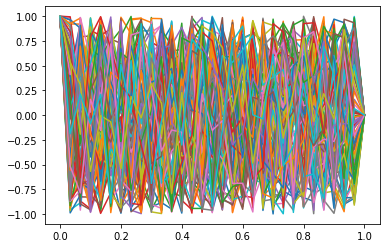

--------------------------------
Population Created
--------------------------------
Number of individuals:  100
Population Edited Parameters:  n_points=30__height=1
-------------------------------- 

iteration          0     |    loss: 4.4118
iteration        500     |    loss: 0.5903
iteration       1000     |    loss: 0.5866
iteration       1500     |    loss: 0.5870
iteration       2000     |    loss: 0.5858
iteration       2500     |    loss: 0.5859
iteration       3000     |    loss: 0.5863
iteration       3500     |    loss: 0.5867
iteration       4000     |    loss: 0.5864
iteration       4500     |    loss: 0.5876
iteration       5000     |    loss: 0.5874
iteration       5500     |    loss: 0.5874
iteration       6000     |    loss: 0.5893
iteration       6500     |    loss: 0.5911
iteration       7000     |    loss: 0.6045
iteration       7500     |    loss: 0.5963
iteration       8000     |    loss: 0.6067
iteration       8500     |    loss: 0.6605
iteration       9000     

<Figure size 432x288 with 0 Axes>

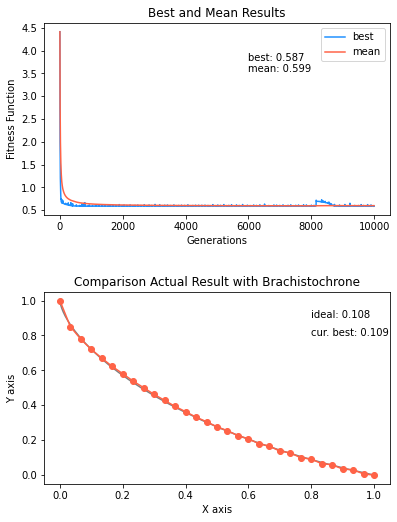

In [58]:
population = Population(Individual, 
                        n_individuals, 
                        n_points=n_points, 
                        height=height, 
                        show_plot=show_plot, 
                        show_info=show_info, 
                        show_debug=show_debug)


individual = population.list_individuals[0][0]

fitness = Fitness(population)
fitness.getBestCurve(individual)


y = torch.tensor(individual.y[1:-1], requires_grad=True)

adam_optimizer = optim.RMSprop([y])

best = []
mean = []

for t in range(n_generations):

    J = fitnessFunction(y, height)

    best.append(J.item())
    mean.append(np.mean(best))

    individual.y[1:-1] = y.detach().tolist()

    if show_info:
      if t%int(n_generations/20)==0:
        print('iteration {:10}     |    loss: {:.4f}'.format(t, J.item()))

    adam_optimizer.zero_grad()
    J.backward()
    adam_optimizer.step()

if show_plot:
  print('\n-------------------------------------')

  fig, axes = plt.subplots(2,1,figsize=(6,8))
  plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
  ax_FF = axes[0]
  ax_state = axes[1]
  fitness.plotFitnessFunction(ax_FF, best, mean)
  fitness.plotState(individual, ax_state, width, height, color='tomato', plot_sol=True, plot_label=True)

  fig.canvas.draw()

## Population Random Generation

Population Diagram: 
--------------------------------


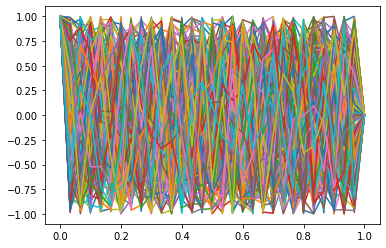

--------------------------------
Population Created
--------------------------------
Number of individuals:  200
Population Edited Parameters:  n_points=30__height=1
-------------------------------- 

Population Diagram: 
--------------------------------


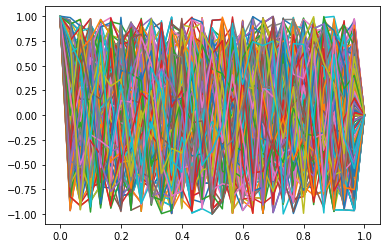

Generation 0, current best = 0.817, current population size = 200
Population Diagram: 
--------------------------------


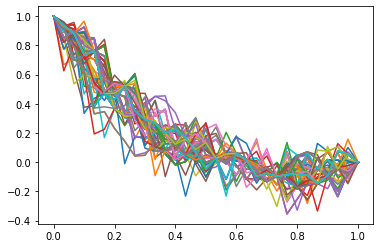

Generation 7500, current best = 0.154, current population size = 200
Population Diagram: 
--------------------------------


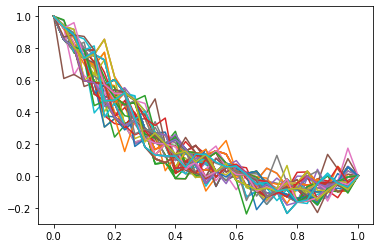

Generation 15000, current best = 0.140, current population size = 200
Population Diagram: 
--------------------------------


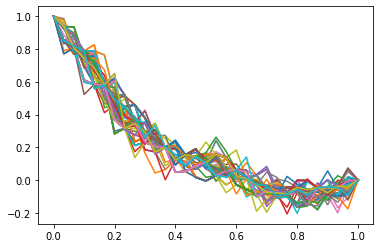

Generation 22500, current best = 0.127, current population size = 200
Population Diagram: 
--------------------------------


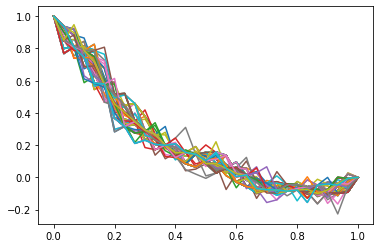

Generation 30000, current best = 0.126, current population size = 200
Population Diagram: 
--------------------------------


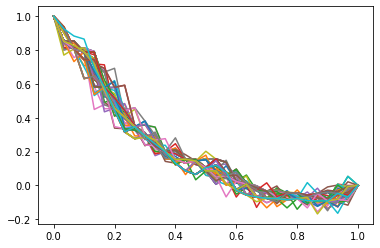

Generation 37500, current best = 0.124, current population size = 200
Population Diagram: 
--------------------------------


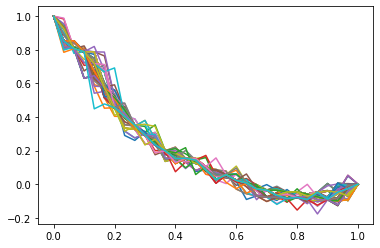

Generation 45000, current best = 0.123, current population size = 200
Population Diagram: 
--------------------------------


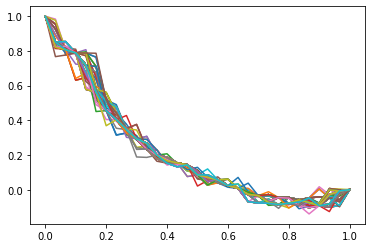

Generation 52500, current best = 0.122, current population size = 200
Population Diagram: 
--------------------------------


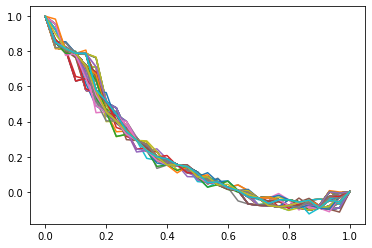

Generation 60000, current best = 0.121, current population size = 200
Population Diagram: 
--------------------------------


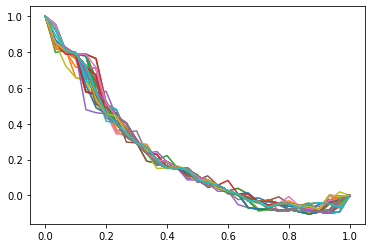

Generation 67500, current best = 0.120, current population size = 200
Population Diagram: 
--------------------------------


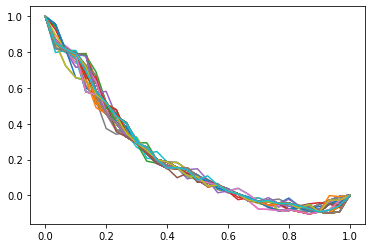

Generation 75000, current best = 0.119, current population size = 200
Population Diagram: 
--------------------------------


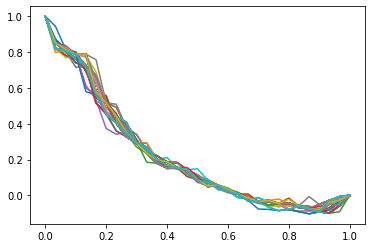

Generation 82500, current best = 0.119, current population size = 200
Population Diagram: 
--------------------------------


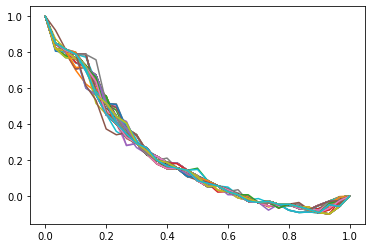

Generation 90000, current best = 0.118, current population size = 200
Population Diagram: 
--------------------------------


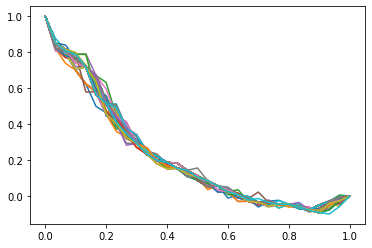

Generation 97500, current best = 0.118, current population size = 200
Population Diagram: 
--------------------------------


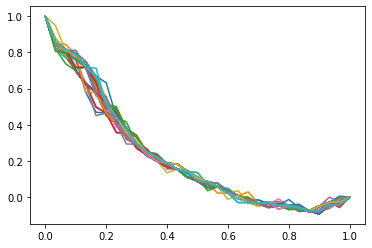

Generation 105000, current best = 0.118, current population size = 200
Population Diagram: 
--------------------------------


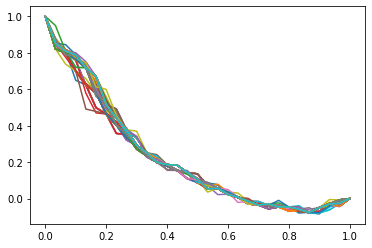

Generation 112500, current best = 0.118, current population size = 200
Population Diagram: 
--------------------------------


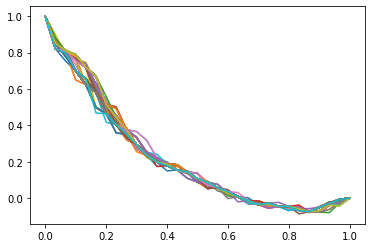

Generation 120000, current best = 0.117, current population size = 200
Population Diagram: 
--------------------------------


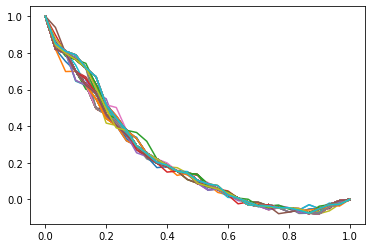

Generation 127500, current best = 0.117, current population size = 200
Population Diagram: 
--------------------------------


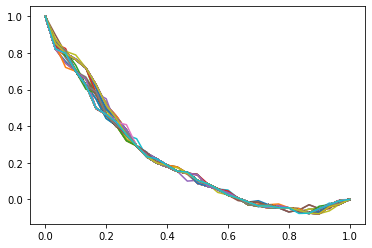

Generation 135000, current best = 0.117, current population size = 200
Population Diagram: 
--------------------------------


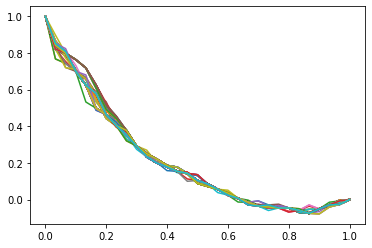

Generation 142500, current best = 0.117, current population size = 200

-------------------------------------
Process Complete
-------------------------------------

Object Fitness:, Short Time, Short Path
Number of Generations 150000
Best Result 0.11649337481145536
Ideal Result 0.10807028670945112
Time Process: 8770.608859300613   

-------------------------------------------



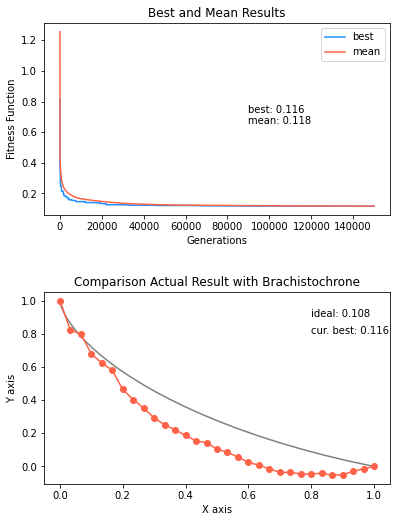

In [71]:
population = Population(Individual, 
                        n_individuals, 
                        n_points=n_points, 
                        height=height, 
                        show_plot=show_plot, 
                        show_info=show_info, 
                        show_debug=show_debug)

GeneticAlgorithm(population=population,
                 generations=n_generations,
                 ps=ps,
                 pc=pc,
                 pm=pm,
                 show_plot=show_plot, 
                 show_info=show_info, 
                 show_debug=show_debug)


Population Diagram: 
--------------------------------


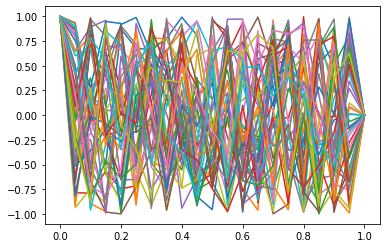

--------------------------------
Population Created
--------------------------------
Number of individuals:  50
Population Edited Parameters:  n_points=20__height=1
-------------------------------- 

Population Diagram: 
--------------------------------


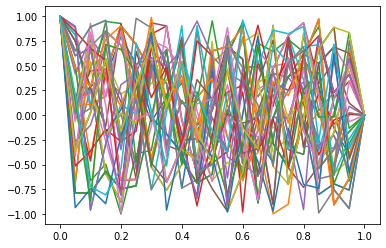

Generation 0, current best = 0.670, current population size = 50
Population Diagram: 
--------------------------------


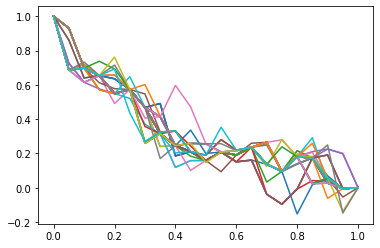

Generation 500, current best = 0.132, current population size = 50
Population Diagram: 
--------------------------------


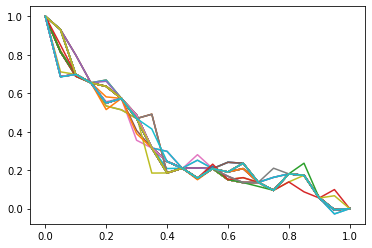

Generation 1000, current best = 0.126, current population size = 50
Population Diagram: 
--------------------------------


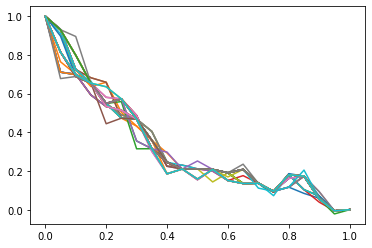

Generation 1500, current best = 0.116, current population size = 50
Population Diagram: 
--------------------------------


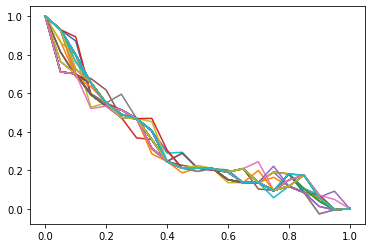

Generation 2000, current best = 0.116, current population size = 50
Population Diagram: 
--------------------------------


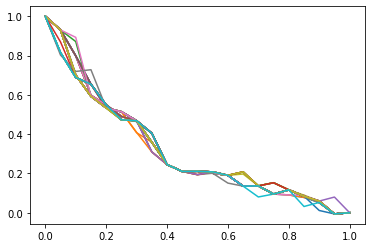

Generation 2500, current best = 0.114, current population size = 50
Population Diagram: 
--------------------------------


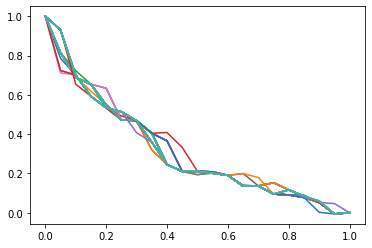

Generation 3000, current best = 0.113, current population size = 50
Population Diagram: 
--------------------------------


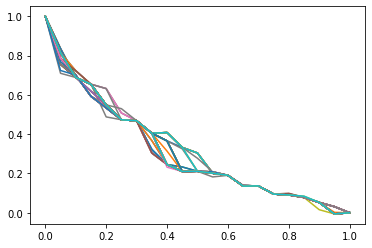

Generation 3500, current best = 0.112, current population size = 50
Population Diagram: 
--------------------------------


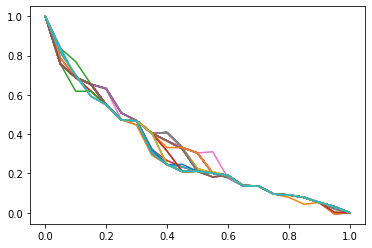

Generation 4000, current best = 0.110, current population size = 50
Population Diagram: 
--------------------------------


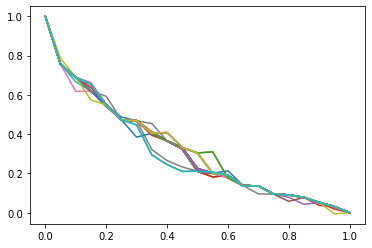

Generation 4500, current best = 0.110, current population size = 50
Population Diagram: 
--------------------------------


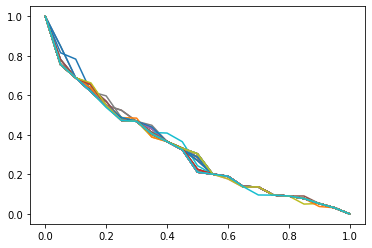

Generation 5000, current best = 0.109, current population size = 50
Population Diagram: 
--------------------------------


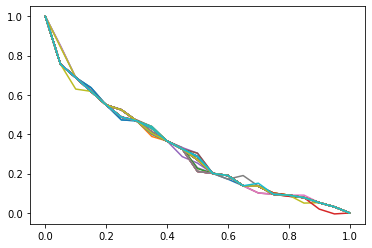

Generation 5500, current best = 0.109, current population size = 50
Population Diagram: 
--------------------------------


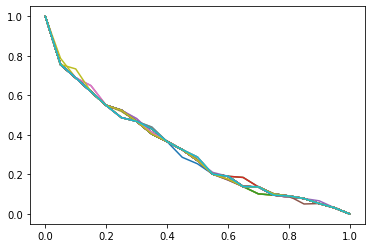

Generation 6000, current best = 0.108, current population size = 50
Population Diagram: 
--------------------------------


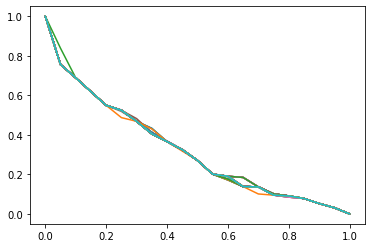

Generation 6500, current best = 0.108, current population size = 50
Population Diagram: 
--------------------------------


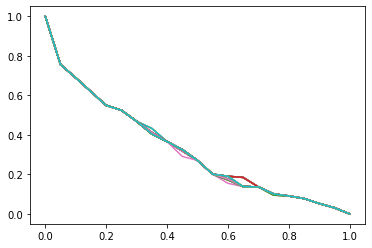

Generation 7000, current best = 0.108, current population size = 50
Population Diagram: 
--------------------------------


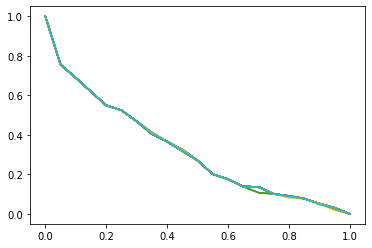

Generation 7500, current best = 0.108, current population size = 50
Population Diagram: 
--------------------------------


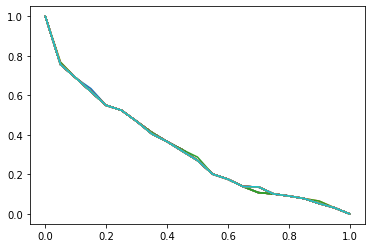

Generation 8000, current best = 0.108, current population size = 50
Population Diagram: 
--------------------------------


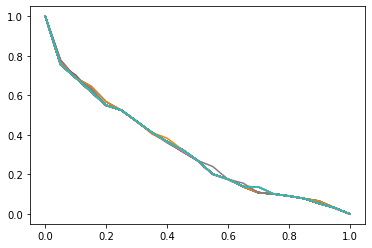

Generation 8500, current best = 0.108, current population size = 50
Population Diagram: 
--------------------------------


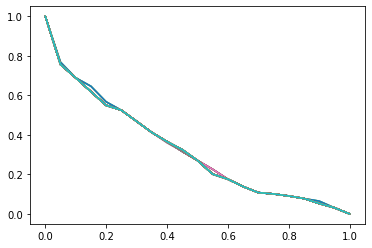

Generation 9000, current best = 0.108, current population size = 50
Population Diagram: 
--------------------------------


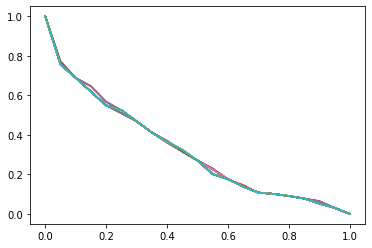

Generation 9500, current best = 0.108, current population size = 50

-------------------------------------
Process Complete
-------------------------------------

Object Fitness:, Short Time, Short Path
Number of Generations 10000
Best Result 0.10756469489584404
Ideal Result 0.10709658794934682
Time Process: 141.40546202659607  

-------------------------------------------



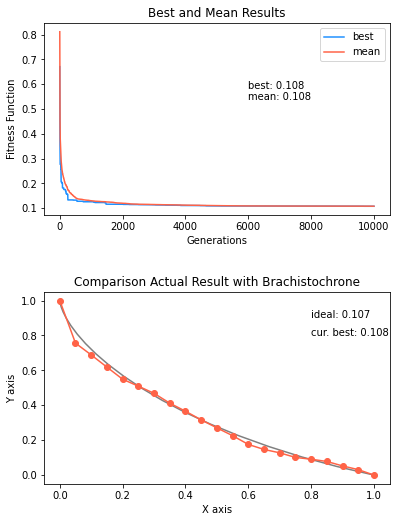

In [79]:
n_dimensions = 1
n_individuals = 50
n_generations = 10000
n_points = 20

# Probabilities
ps = 0.7 # selection
pc = 1 # crossover
pm = 0.3 # mutation Change less mutation


population = Population(Individual, 
                        n_individuals, 
                        n_points=n_points, 
                        height=height, 
                        show_plot=show_plot, 
                        show_info=show_info, 
                        show_debug=show_debug)

GeneticAlgorithm(population=population,
                 generations=n_generations,
                 ps=ps,
                 pc=pc,
                 pm=pm,
                 show_plot=show_plot, 
                 show_info=show_info, 
                 show_debug=show_debug)

Population Diagram: 
--------------------------------


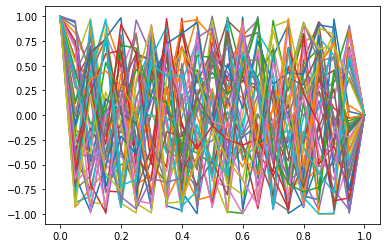

--------------------------------
Population Created
--------------------------------
Number of individuals:  50
Population Edited Parameters:  n_points=20__height=1
-------------------------------- 

Population Diagram: 
--------------------------------


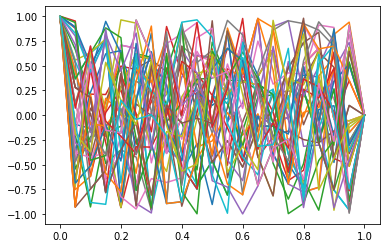

Generation 0, current best = 0.532, current population size = 50
Population Diagram: 
--------------------------------


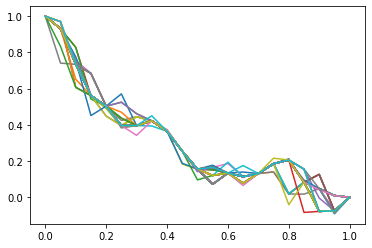

Generation 1000, current best = 0.125, current population size = 50
Population Diagram: 
--------------------------------


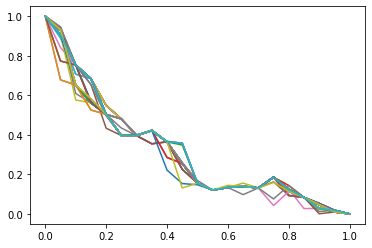

Generation 2000, current best = 0.120, current population size = 50
Population Diagram: 
--------------------------------


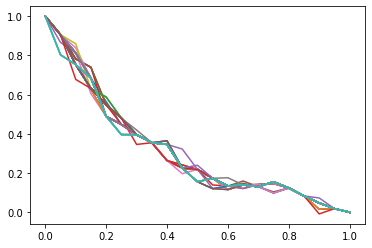

Generation 3000, current best = 0.112, current population size = 50
Population Diagram: 
--------------------------------


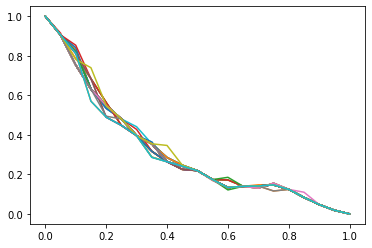

Generation 4000, current best = 0.111, current population size = 50
Population Diagram: 
--------------------------------


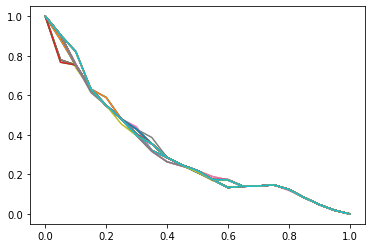

Generation 5000, current best = 0.111, current population size = 50
Population Diagram: 
--------------------------------


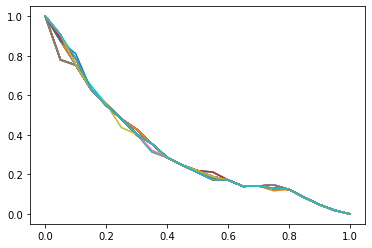

Generation 6000, current best = 0.110, current population size = 50
Population Diagram: 
--------------------------------


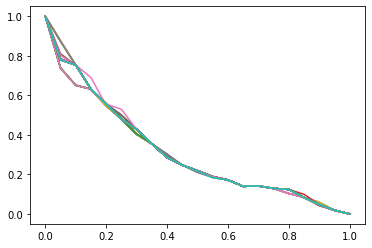

Generation 7000, current best = 0.109, current population size = 50
Population Diagram: 
--------------------------------


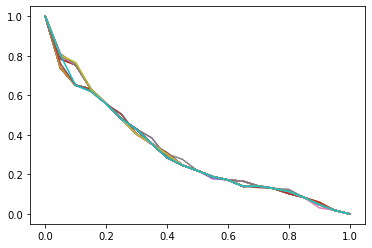

Generation 8000, current best = 0.109, current population size = 50
Population Diagram: 
--------------------------------


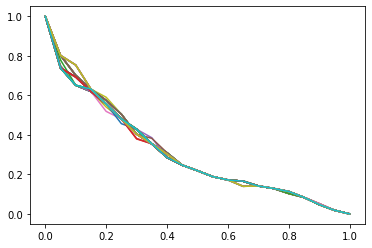

Generation 9000, current best = 0.109, current population size = 50
Population Diagram: 
--------------------------------


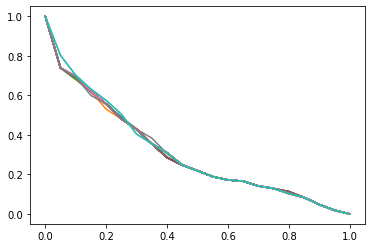

Generation 10000, current best = 0.108, current population size = 50
Population Diagram: 
--------------------------------


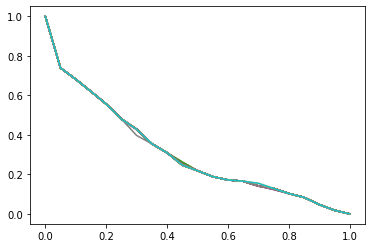

Generation 11000, current best = 0.108, current population size = 50
Population Diagram: 
--------------------------------


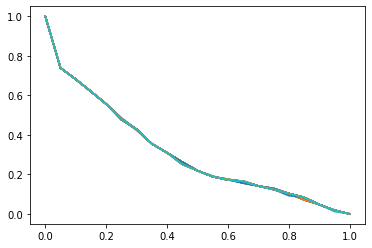

Generation 12000, current best = 0.108, current population size = 50
Population Diagram: 
--------------------------------


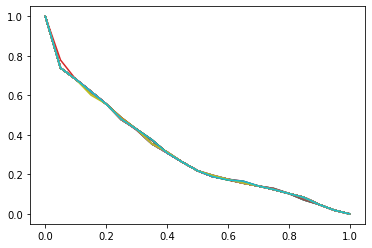

Generation 13000, current best = 0.108, current population size = 50
Population Diagram: 
--------------------------------


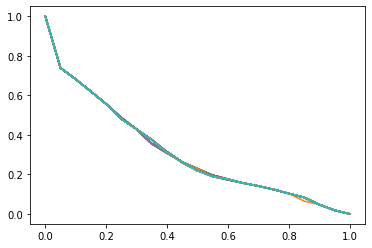

Generation 14000, current best = 0.108, current population size = 50
Population Diagram: 
--------------------------------


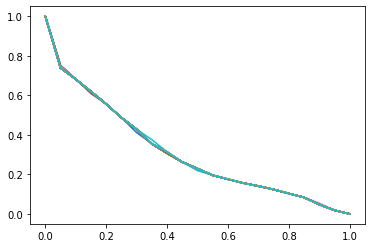

Generation 15000, current best = 0.108, current population size = 50
Population Diagram: 
--------------------------------


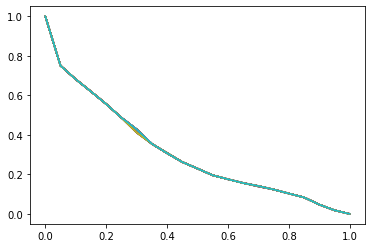

Generation 16000, current best = 0.108, current population size = 50
Population Diagram: 
--------------------------------


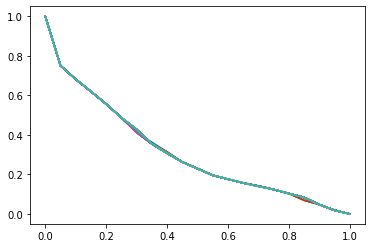

Generation 17000, current best = 0.108, current population size = 50
Population Diagram: 
--------------------------------


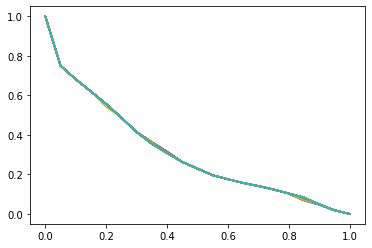

Generation 18000, current best = 0.108, current population size = 50
Population Diagram: 
--------------------------------


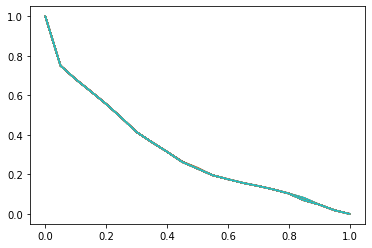

Generation 19000, current best = 0.108, current population size = 50

-------------------------------------
Process Complete
-------------------------------------

Object Fitness:, Short Time, Short Path
Number of Generations 20000
Best Result 0.107811516915476
Ideal Result 0.10709658794934682
Time Process: 278.1191956996918   

-------------------------------------------



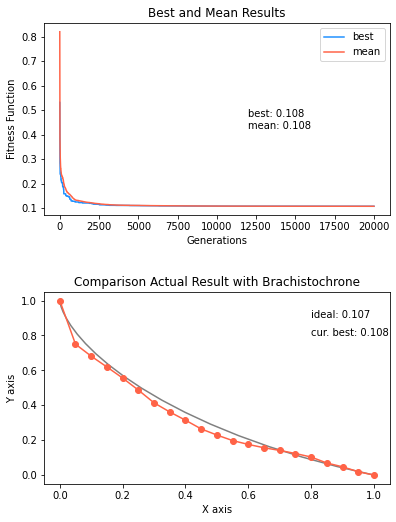

In [81]:
population = Population(Individual, 
                        n_individuals, 
                        n_points=n_points, 
                        height=height, 
                        show_plot=show_plot, 
                        show_info=show_info, 
                        show_debug=show_debug)

GeneticAlgorithm(population=population,
                 generations=n_generations,
                 ps=ps,
                 pc=pc,
                 pm=pm,
                 show_plot=show_plot, 
                 show_info=show_info, 
                 show_debug=show_debug)

# Extra

## NSGAII

In [ ]:
globals()

In [46]:
frames = inspect.stack()
caller_frame = frames[-1][0]
for (k,v) in globals():
  if not k.startswith('__') and not k.startswith('_'):
    print(k,v)

ValueError: ignored

In [47]:
h_hello = True
h_value2=1
h_params = "Empty"

In [48]:
import inspect

if globals is None:
  frames = inspect.stack()
  caller_frame = frames[-1][0]
  globals = dict((k,v) for (k,v) in caller_frame.f_globals.items() if k.startswith('h_'))

In [ ]:
from collections import OrderedDict

import json

globals__ = globals()
new = {}

for key, value in sorted(globals__.items()):
  if not key.startswith('_'):
    new[key] = value
    print(key, value)


json_object = json.dumps(new, indent = 4) 
print(json_object)

In [49]:
print(globals)

<built-in function globals>


In [53]:
for k,v in pairs(_G) do
    print("Global", k, "value", v)
    io.open("test.txt", "a")
    io.write("Global", k, "value", v, "\n")
end

SyntaxError: ignored

In [39]:
x = 10
print(globals()['objectives'], globals()['n_dimensions'], ['n_individuals'])

['Short Time', 'Short Path'] 2 ['n_individuals']


In [30]:
locals().locals()

AttributeError: ignored

In [28]:
for strl in globals():
    nline= "%s:\n"%(strl)
    print(nline)

__name__:



RuntimeError: ignored

In [ ]:
dir()

In [ ]:
locals()

In [ ]:
for name in vars().keys():
  print(name)

In [ ]:
for value in vars().values():
  print(value)

In [ ]:
import sys, pprint
sys.displayhook = pprint.pprint
globals()